In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from collections import defaultdict
from collections import Counter

# load data
parts = pd.read_csv('Data/parts.csv')
sets = pd.read_csv('Data/sets.csv')
sets = sets[sets["year"] <= 2023]
colors = pd.read_csv('Data/colors.csv')
inventories = pd.read_csv('Data/inventories.csv')
inventory_parts = pd.read_csv('Data/inventory_parts.csv')
minifigs = pd.read_csv('Data/inventory_minifigs.csv')
inventory_sets = pd.read_csv('Data/inventory_sets.csv')

In [2]:
##### basic analysis #####

# part analysis
most_common_parts = parts['part_num'].value_counts().idxmax()
print(f"The most common part is: {most_common_parts}")

# set analysis
sets['num_parts'].describe()
print(f"The mean part number of a set is: {sets['num_parts'].mean()}")

# color analysis
most_common_color = colors['rgb'].value_counts().idxmax()
print(f"The most common colour is: {most_common_color}")

# inventory analysis
most_unique_inventory = inventories['set_num'].value_counts().idxmin()
print(f"The set with the most unique inventorylements is: {most_unique_inventory}")


The most common part is: 003381
The mean part number of a set is: 161.55525716886663
The most common colour is: 05131D
The set with the most unique inventorylements is: fig-009269


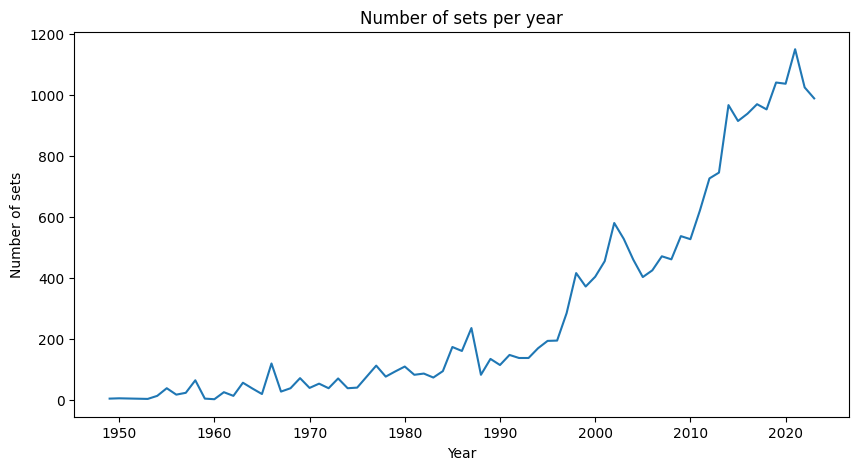

In [3]:
##### analyse how many sets were created over the years #####

sets['year'] = pd.to_numeric(sets['year'], errors='coerce')

# calculate number of sets per year
sets_per_year = sets.groupby('year').size()

# plot
plt.figure(figsize=(10, 5))
plt.plot(sets_per_year)
plt.xlabel('Year')
plt.ylabel('Number of sets')
plt.title('Number of sets per year')
plt.show()


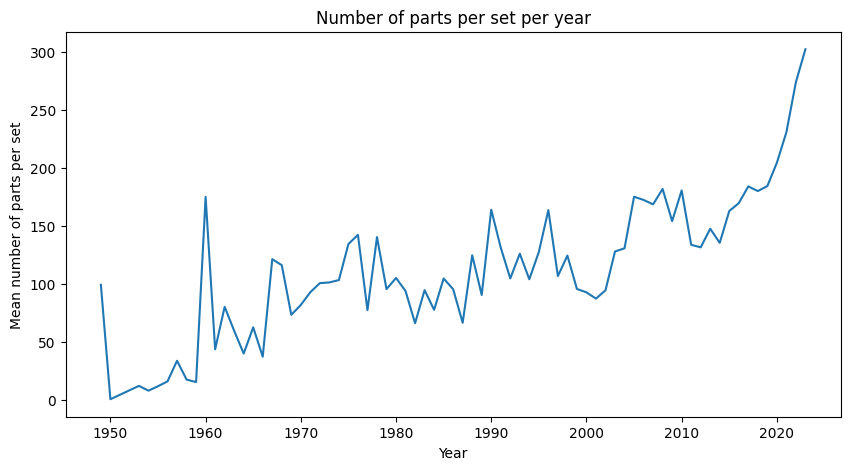

In [4]:
##### analyse the number of parts per set per years #####

sets['year'] = pd.to_numeric(sets['year'], errors='coerce')

# number of parts per set per year
average_parts_per_year = sets.groupby('year')['num_parts'].mean()
plt.figure(figsize=(10, 5))
plt.plot(average_parts_per_year)
plt.xlabel('Year')
plt.ylabel('Mean number of parts per set')
plt.title('Number of parts per set per year')
plt.show()

Predicted number of parts in 2025 is 215.8617283071626


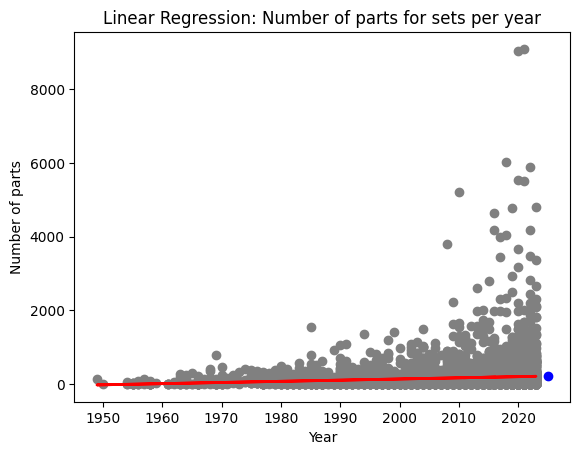

In [5]:
##### Linear regression for the number of parts for each set #####

# define the dependend and independend variable
X = sets['year'].values.reshape(-1,1)
y = sets['num_parts'].values.reshape(-1,1)

# split data in training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# create and train model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

# make prediction on test data
y_pred = regressor.predict(X_test)

# prediction for fucutre year
future_year = [[2025]]
predicted_num_parts = regressor.predict(future_year)
print(f"Predicted number of parts in {future_year[0][0]} is {predicted_num_parts[0][0]}")

# create a plot
plt.scatter(X_test, y_test, color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.scatter(future_year, predicted_num_parts, color='blue')
plt.xlabel('Year')
plt.ylabel('Number of parts')
plt.title('Linear Regression: Number of parts for sets per year')
plt.show()

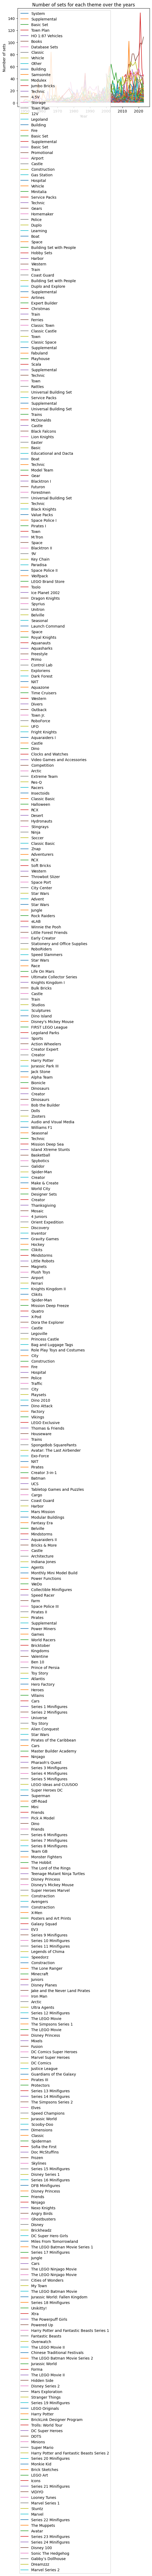

In [6]:
##### analyse the number of sets for each theme over the years #####

sets['year'] = pd.to_numeric(sets['year'], errors='coerce')

# group the data after year and theme and count the number of sets
theme_counts_per_year = sets.groupby(['year', 'theme_id']).size().reset_index(name='counts')

# for each theme, plot the number of sets over the years
themes = theme_counts_per_year['theme_id'].unique()
theme = pd.read_csv('Data/themes.csv')

for id in themes:
    data = theme_counts_per_year[theme_counts_per_year['theme_id'] == id]
    plt.plot(data['year'], data['counts'], label=theme.loc[theme['id'] == id, 'name'].values[0])

plt.xlabel('Year')
plt.ylabel('Number of sets')
plt.title('Number of sets for each theme over the years')
plt.legend()
plt.show()

Index(['Books', 'Star Wars', 'Key Chain', 'Friends', 'Gear', 'Ninjago',
       'Technic', 'Bionicle', 'Stationery and Office Supplies', 'Houseware'],
      dtype='object', name='name_y')


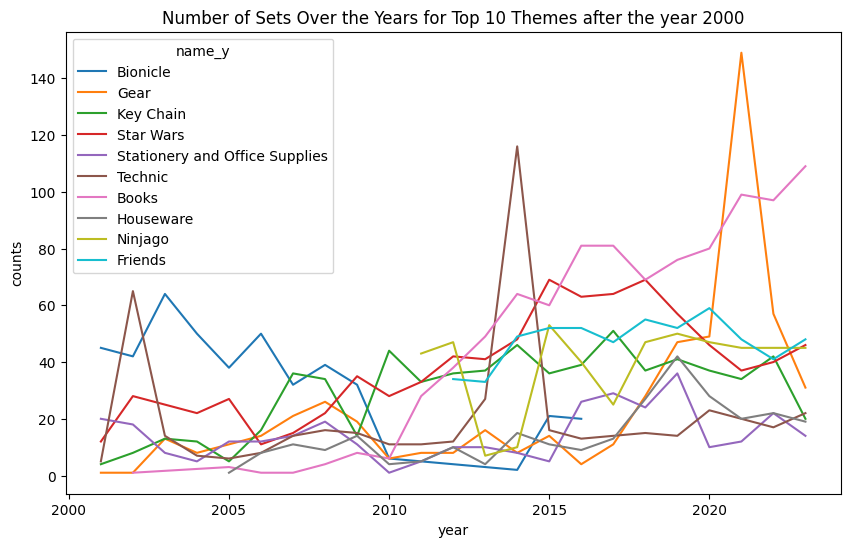

In [7]:
##### number of sets for top 10 themes over the years #####

# Merge the sets and themes data
data = pd.merge(sets, theme, left_on='theme_id', right_on='id')

# Convert the year to integer
data['year'] = data['year'].astype(int)

# Filter the data for recent years
recent_data = data[data['year'] > 2000]

# Find the top 10 themes
top_themes = recent_data['name_y'].value_counts().nlargest(10).index
print(top_themes)

# Filter the data for the top 10 themes
filtered_data = recent_data[recent_data['name_y'].isin(top_themes)]

# Group the data by year and theme and count the number of sets
grouped_data = filtered_data.groupby(['year', 'name_y']).size().reset_index(name='counts')

# Plot the number of sets over the years for each theme
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='year', y='counts', hue='name_y')
plt.title('Number of Sets Over the Years for Top 10 Themes after the year 2000')
plt.show()


Linear regression model for Books: coefficient = 6.0455574419920755, intercept = -12124.375353706846
Linear regression model for Star Wars: coefficient = 1.8883399209486162, intercept = -3761.0790513833986
Linear regression model for Key Chain: coefficient = 1.4347826086956517, intercept = -2857.4347826086946
Linear regression model for Friends: coefficient = 0.9160839160839159, intercept = -1800.6993006993005
Linear regression model for Gear: coefficient = 2.6463074230023196, intercept = -5300.712541987986
Linear regression model for Ninjago: coefficient = 1.4615384615384617, intercept = -2909.153846153846
Linear regression model for Technic: coefficient = 0.2015810276679843, intercept = -384.66798418972354
Linear regression model for Bionicle: coefficient = -2.8497109826589595, intercept = 5755.2658959537575
Linear regression model for Stationery and Office Supplies: coefficient = 0.3893280632411067, intercept = -768.9367588932805
Linear regression model for Houseware: coefficient = 

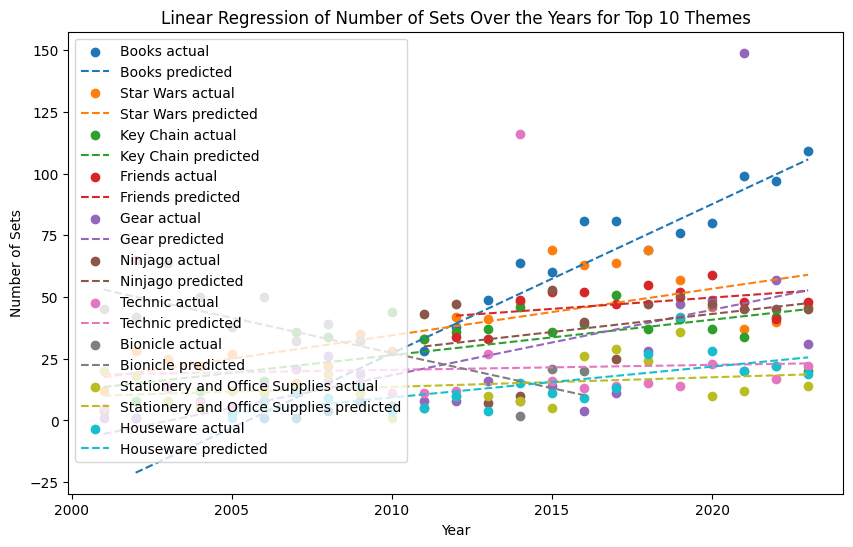

In [8]:
##### linear regression for the themes #####

# Create a new plot
plt.figure(figsize=(10, 6))

# For each theme
for theme in top_themes:
    # Filter the data for the current theme
    theme_data = grouped_data[grouped_data['name_y'] == theme]
    
    # Get the years (X) and counts (y)
    X = theme_data['year'].values.reshape(-1, 1)
    y = theme_data['counts'].values.reshape(-1, 1)
    
    # Fit the linear regression model
    model = LinearRegression().fit(X, y)
    print(f"Linear regression model for {theme}: coefficient = {model.coef_[0][0]}, intercept = {model.intercept_[0]}")
    
    # Get the start and end years for the current theme
    start_year = theme_data['year'].min()
    end_year = theme_data['year'].max()
    
    # Generate a range of years from start to end
    years_range = np.arange(start_year, end_year+1).reshape(-1, 1)
    
    # Predict the counts for the range of years using the fitted model
    counts_pred = model.predict(years_range)
    
    # Plot the original data
    plt.scatter(X, y, label=f'{theme} actual')
    
    # Plot the linear regression line
    plt.plot(years_range, counts_pred, linestyle='--', label=f'{theme} predicted')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Number of Sets')
plt.legend()
plt.title('Linear Regression of Number of Sets Over the Years for Top 10 Themes')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21970 entries, 0 to 21969
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   set_num    21970 non-null  object 
 1   name_x     21970 non-null  object 
 2   year       21970 non-null  int64  
 3   theme_id   21970 non-null  int64  
 4   num_parts  21970 non-null  int64  
 5   img_url    21970 non-null  object 
 6   id         21970 non-null  int64  
 7   name_y     21970 non-null  object 
 8   parent_id  11746 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   inventory_id  4372 non-null   int64  
 1   set_num       4372 non-null   object 
 2   quantity      4372 non-null   int64  
 3   name_x        4372 non-null   object 
 4   year          4372 n

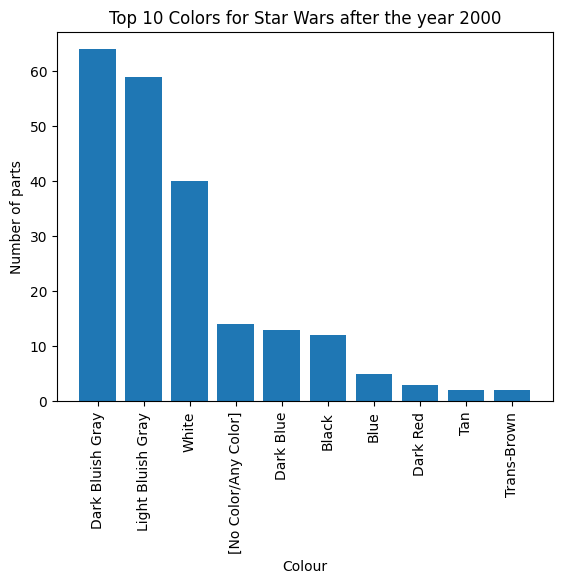

In [9]:
##### analyse the data with the colour ####
themes = pd.read_csv('Data/themes.csv')

# merge data
sets_with_themes = pd.merge(sets, themes, left_on='theme_id', right_on='id')
sets_with_themes.info()
inventory_sets_with_themes =pd.merge(inventory_sets, sets_with_themes, left_on='set_num', right_on='set_num')
inventory_sets_with_themes.info()
inventory_parts_with_colours = pd.merge(inventory_parts, colors, left_on='color_id', right_on='id')
inventory_parts_with_colours.info()
full_data =pd.merge(inventory_sets_with_themes, inventory_parts_with_colours, left_on='inventory_id', right_on='inventory_id')
full_data.info()

# Filter the data for recent years
recent_data = full_data[full_data['year'] > 2000]

# show data for specific theme
theme_name = 'Star Wars'  
theme_data = recent_data[recent_data['name_y'] == theme_name]

# create counter
color_counter = Counter()

# count number of parts for each theme for the different sets
for index, row in theme_data.iterrows():
    color_counter[row['name']] += row['quantity_y']

# plot 
colors, counts = zip(*color_counter.most_common(10))
plt.bar(colors, counts)
plt.xlabel('Colour')
plt.ylabel('Number of parts')
plt.title(f'Top 10 Colors for {theme_name} after the year 2000')
plt.xticks(rotation=90)
plt.show()


Top 10 Colors for Stationery and Office Supplies
Yellow: 249
Black: 94
Red: 87
White: 69
Light Gray: 56
[No Color/Any Color]: 5
Trans-Clear: 4
Brown: 4
Chrome Gold: 4
Blue: 3


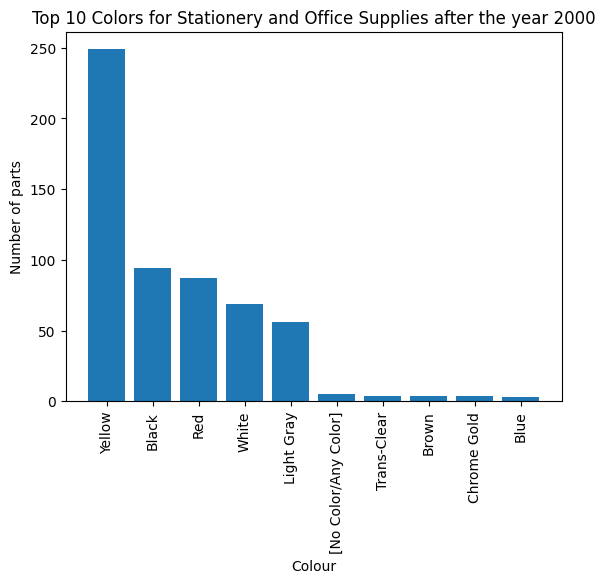

Top 10 Colors for Star Wars
Dark Bluish Gray: 64
Light Bluish Gray: 59
White: 40
[No Color/Any Color]: 14
Dark Blue: 13
Black: 12
Blue: 5
Dark Red: 3
Tan: 2
Trans-Brown: 2


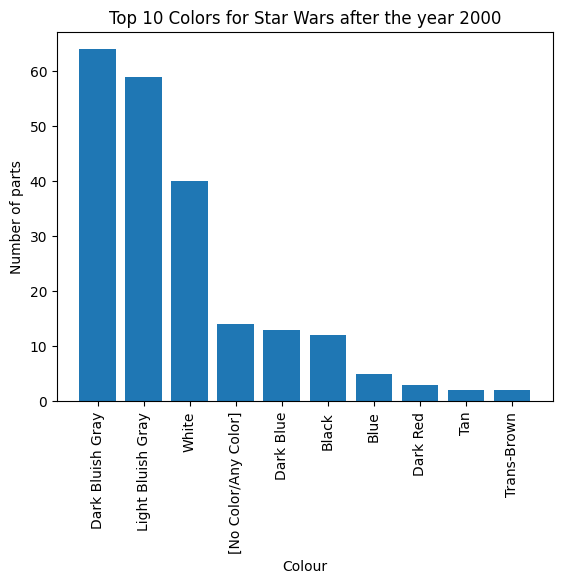

Top 10 Colors for Bionicle
Dark Green: 46
Black: 45
Pearl Light Gray: 44
Dark Bluish Gray: 33
Light Brown: 20
Light Bluish Gray: 16
Pearl Gold: 15
Brown: 14
Pearl White: 11
Dark Gray: 10


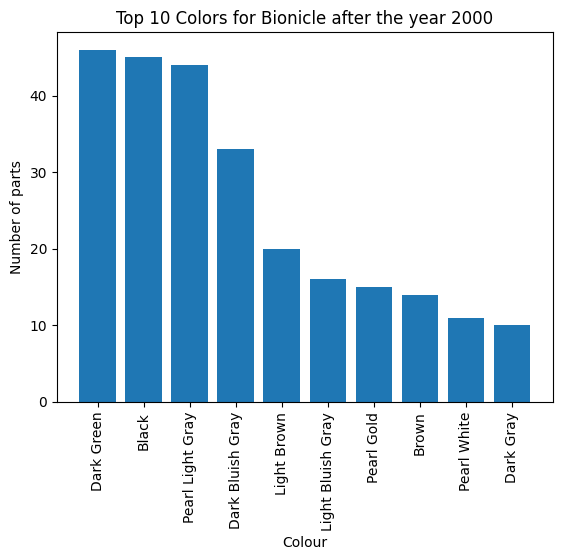

Top 10 Colors for 9V
Dark Gray: 200
Black: 56
White: 8
Chrome Silver: 8


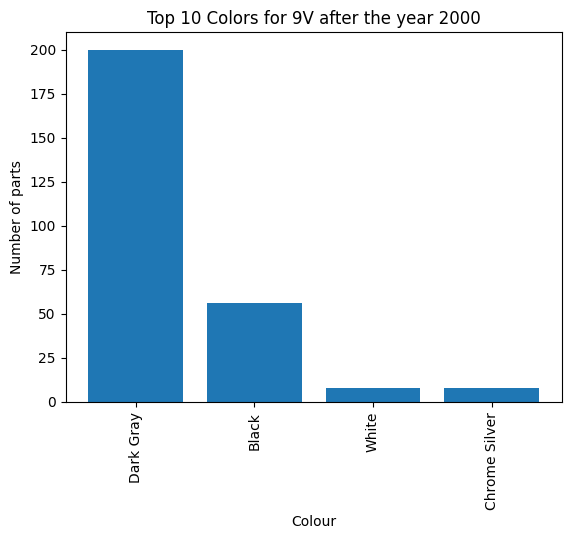

Top 10 Colors for Indiana Jones
Dark Bluish Gray: 53
Light Bluish Gray: 17
Reddish Brown: 13
Black: 6
Dark Green: 5
Red: 4
Sand Green: 4
[No Color/Any Color]: 2
Green: 2
Dark Brown: 2


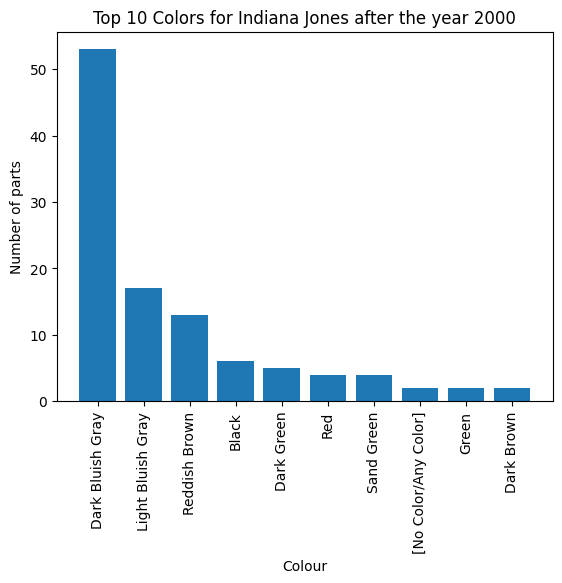

Top 10 Colors for Hockey
[No Color/Any Color]: 16
White: 8
Black: 4
Orange: 4
Green: 4
Blue: 4
Red: 4


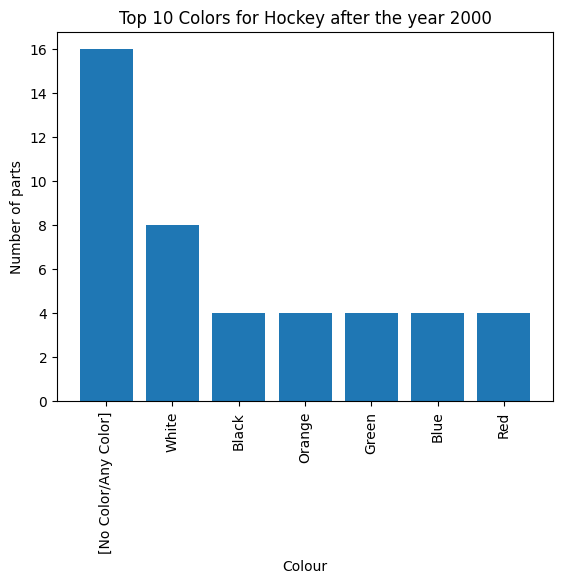

Top 10 Colors for Scooby-Doo
Reddish Brown: 84
Medium Azure: 12


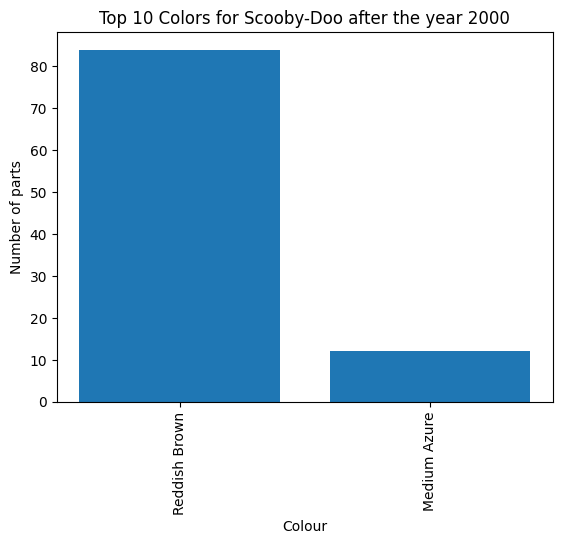

Top 10 Colors for Knights Kingdom II
[No Color/Any Color]: 10
Red: 6


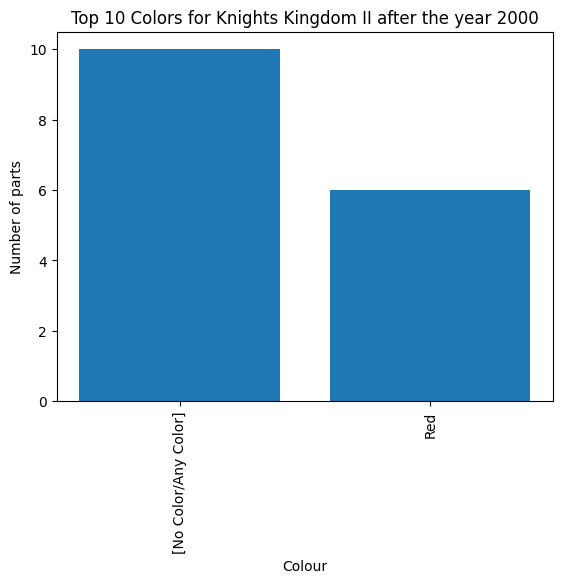

Top 10 Colors for Video Games and Accessories
White: 24


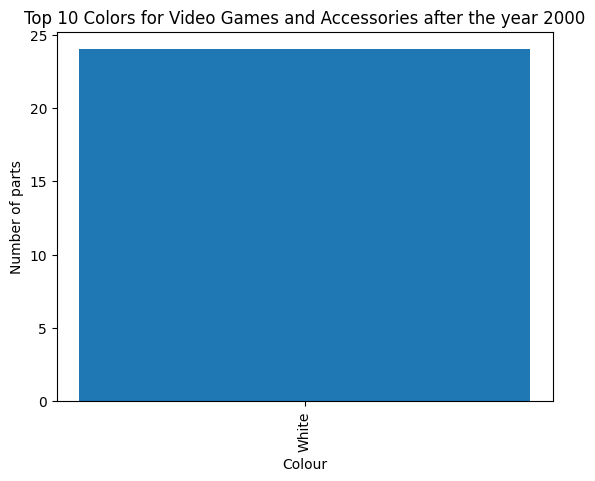

Top 10 Colors for X-Pod
[Unknown]: 10


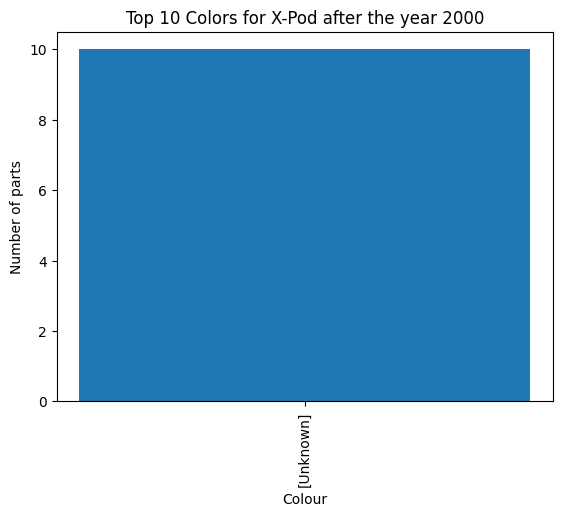

In [10]:
##### plot the top 10 colors, for each of the top 10 themes ######

# Filter the data for recent years
recent_data = full_data[full_data['year'] > 2000]

# Get the top 10 themes
top_themes = recent_data['name_y'].value_counts().nlargest(10).index

# For each of the top 10 themes, plot the top 10 colors
for theme in top_themes:
    theme_data = recent_data[recent_data['name_y'] == theme]
    
    # create counter
    color_counter = Counter()
    
    # count number of parts for each theme for the different sets
    for index, row in theme_data.iterrows():
        color_counter[row['name']] += row['quantity_y']
    
    # print top 10 colors
    print(f'Top 10 Colors for {theme}')
    for color, count in color_counter.most_common(10):
        print(f'{color}: {count}')
    
    # plot 
    colors, counts = zip(*color_counter.most_common(10))
    plt.bar(colors, counts)
    plt.xlabel('Colour')
    plt.ylabel('Number of parts')
    plt.title(f'Top 10 Colors for {theme} after the year 2000')
    plt.xticks(rotation=90)
    plt.show()

Top 10 Colors for DOTS
Trans-Clear: 4
Medium Azure: 4


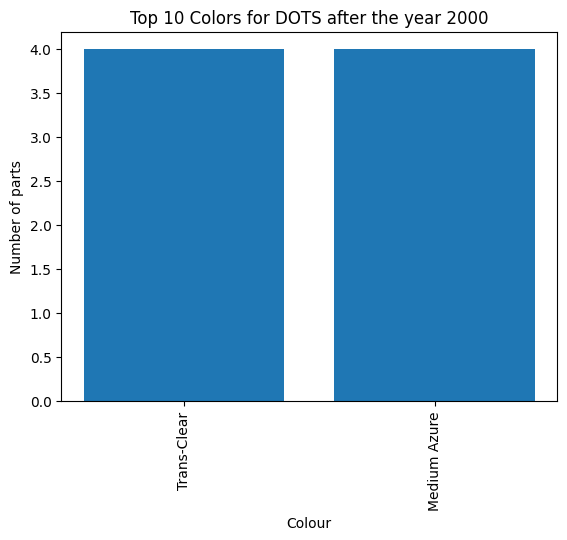

Top 10 Colors for Classic
[No Color/Any Color]: 3


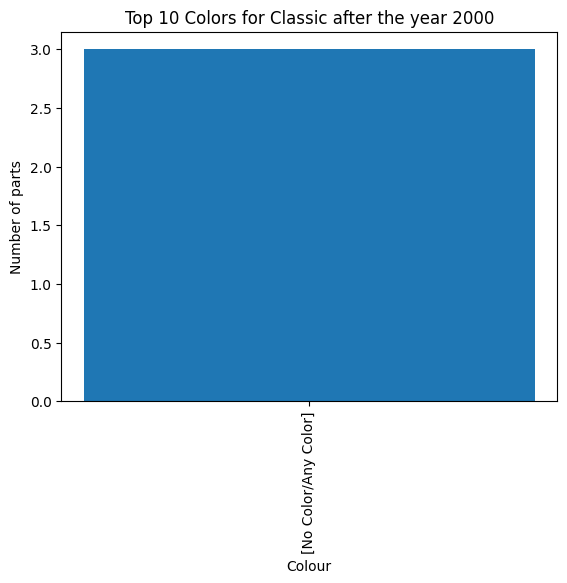

Top 10 Colors for Traffic
Bright Light Orange: 5


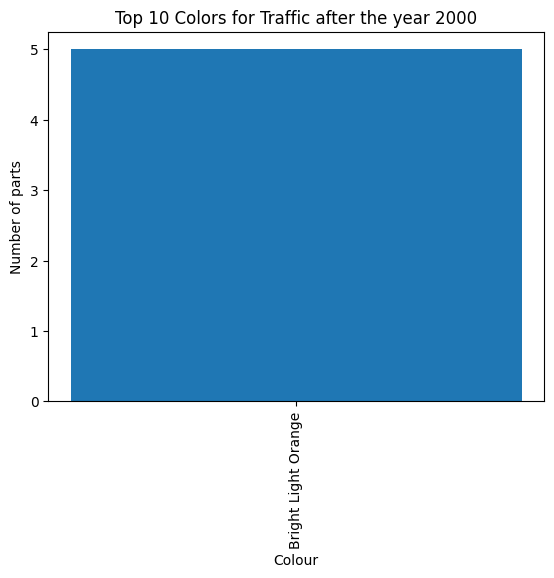

Top 10 Colors for Other
Trans-Clear: 3
White: 1


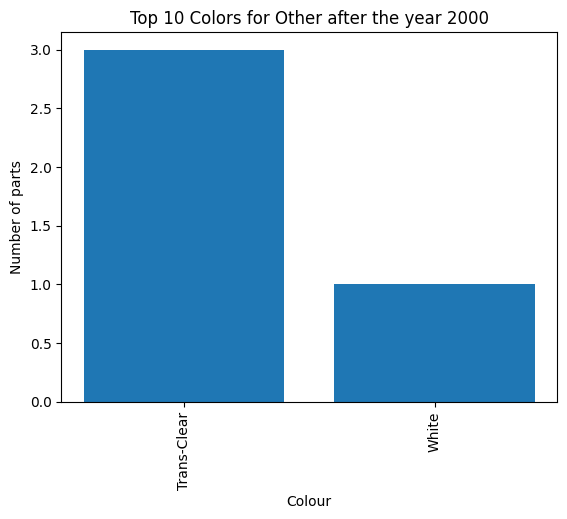

In [17]:
##### plot the top 10 colors, for each of the top 10 themes in a specific year######

# Filter the data for recent years
specific_data = full_data[full_data['year'] == 2020]

# Get the top 10 themes
top_themes = specific_data['name_y'].value_counts().nlargest(10).index

# For each of the top 10 themes, plot the top 10 colors
for theme in top_themes:
    theme_data = recent_data[recent_data['name_y'] == theme]
    
    # create counter
    color_counter = Counter()
    
    # count number of parts for each theme for the different sets
    for index, row in theme_data.iterrows():
        color_counter[row['name']] += row['quantity_y']
    
    # print top 10 colors
    print(f'Top 10 Colors for {theme}')
    for color, count in color_counter.most_common(10):
        print(f'{color}: {count}')
    
    # plot 
    colors, counts = zip(*color_counter.most_common(10))
    plt.bar(colors, counts)
    plt.xlabel('Colour')
    plt.ylabel('Number of parts')
    plt.title(f'Top 10 Colors for {theme} after the year 2000')
    plt.xticks(rotation=90)
    plt.show()
